In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torchvision.models as models
from cifar_utils import get_datasets_res, plot, show_preds
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score as acc
from tqdm.notebook import tqdm as bar
import time
import matplotlib.pyplot as plt

In [3]:
def fit(net, crit, opt, train, val, maxlr=0.1, n_epochs=1):
    n_batches = len(train) * n_epochs
    total_steps = n_batches
    sched = optim.lr_scheduler.OneCycleLR(opt, maxlr, total_steps=total_steps)
    lrs = []
    for epoch in range(n_epochs):
        epoch_loss = []
        epoch_acc = []
        val_loss = []
        val_acc = []
        net.train()
        for X, y in bar(train):
            opt.zero_grad()
            p = net(X)
            v, i = p.max(axis=1)
            epoch_acc.append(acc(y, i))
            loss = crit(p, y)
            epoch_loss.append(loss.item())
            loss.backward()
            opt.step()
            lrs.append(sched.state_dict()["_last_lr"][0])
            sched.step()
        with torch.no_grad():
            net.eval()
            for X, y in val:
                p = net(X)
                v, i = p.max(axis=1)
                val_loss.append(crit(p, y).item())
                val_acc.append(acc(y, i))
        print(f"Epoch:{epoch + 1}, T Loss:{np.mean(epoch_loss):.3f}, T acc:{np.mean(epoch_acc):.3f} V Loss:{np.mean(val_loss):.3f}, V acc:{np.mean(val_acc):.3f}")
    return lrs

In [4]:
def fit_s(net, crit, opt, train, val, n_epochs=1):
    for epoch in range(n_epochs):
        epoch_loss = []
        epoch_acc = []
        val_loss = []
        val_acc = []
        net.train()
        for X, y in bar(train):
            opt.zero_grad()
            p = net(X)
            v, i = p.max(axis=1)
            epoch_acc.append(acc(y, i))
            loss = crit(p, y)
            epoch_loss.append(loss.item())
            loss.backward()
            opt.step()
        with torch.no_grad():
            net.eval()
            for X, y in val:
                p = net(X)
                v, i = p.max(axis=1)
                val_loss.append(crit(p, y).item())
                val_acc.append(acc(y, i))
        print(f"Epoch:{epoch + 1}, T Loss:{np.mean(epoch_loss):.3f}, T acc:{np.mean(epoch_acc):.3f} V Loss:{np.mean(val_loss):.3f}, V acc:{np.mean(val_acc):.3f}")

In [20]:
resnet = models.resnet18(pretrained=True)
#for param in resnet.parameters():
#    param.requires_grad = False

In [14]:
import re
def is_pool_type(l): return re.search(r'Pool[123]d$', l.__class__.__name__)

In [6]:
ll = list(enumerate(resnet.children()))

In [13]:
ll

[(0,
  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)),
 (1,
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 (2, ReLU(inplace=True)),
 (3,
  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)),
 (4,
  Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64

In [21]:
FOLDER = ".//data//cifar//"
training_set, validation_set = get_datasets_res(FOLDER)

In [22]:
training_gen = DataLoader(training_set, batch_size=64, shuffle=True, num_workers=4)
valid_gen = DataLoader(validation_set, batch_size=64, num_workers=4)

In [23]:
resnet.fc = nn.Linear(512, 10)
crit = nn.CrossEntropyLoss()
opt = optim.Adam(resnet.parameters(), weight_decay=0.01)

In [ ]:
lr = fit_s(resnet, crit, opt, training_gen, valid_gen, n_epochs=10)


Epoch:1, T Loss:1.181, T acc:0.604 V Loss:1.495, V acc:0.508



Epoch:2, T Loss:1.032, T acc:0.652 V Loss:1.098, V acc:0.629



Epoch:3, T Loss:0.956, T acc:0.680 V Loss:1.015, V acc:0.656



Epoch:4, T Loss:0.927, T acc:0.693 V Loss:0.895, V acc:0.700



Epoch:5, T Loss:0.895, T acc:0.704 V Loss:0.907, V acc:0.696



Epoch:6, T Loss:0.869, T acc:0.711 V Loss:0.889, V acc:0.708



Epoch:7, T Loss:0.851, T acc:0.718 V Loss:0.904, V acc:0.697


### lt.plot(lr)
plt.show()

In [132]:
def lr_finder(net, crit, train, maxlr=1, minlr=1e-8, beta = 0.98):
    opt = optim.SGD(net.parameters(), lr=minlr)
    gamma = (maxlr/minlr)**(1/(len(train) - 1))
    sched = optim.lr_scheduler.StepLR(opt, step_size=1, gamma=gamma)
    losses = []
    lrs = []
    avg_loss = 0.
    best_loss = 1000000.
    batch_num = 0
    for X, y in bar(train):
        batch_num += 1
        p = net(X)
        v, i = p.max(axis=1)
        loss = crit(p, y)
        avg_loss = beta * avg_loss + (1-beta) *loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        if smoothed_loss > 4 * best_loss:
            break
        if smoothed_loss < best_loss:
            best_loss = smoothed_loss
        losses.append(smoothed_loss)
        lrs.append(sched.state_dict()["_last_lr"][0])
        loss.backward()
        opt.step()
        sched.step()
    return losses, lrs

In [133]:
losses, lrs = lr_finder(resnet, crit, training_gen)

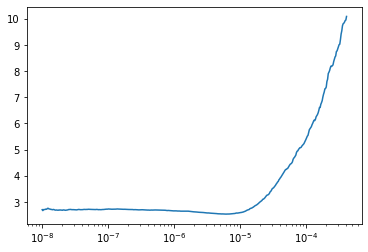

In [134]:
plt.plot(lrs, losses)
plt.xscale('log')
plt.show()

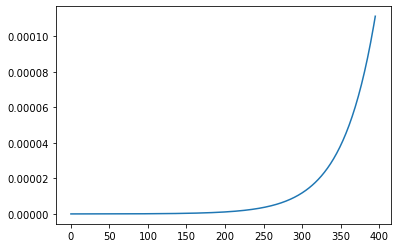

In [129]:
plt.plot(lrs)
plt.show()

In [58]:
sched.state_dict()

{'step_size': 1,
 'gamma': 1.01,
 'base_lrs': [0.001],
 'last_epoch': 1,
 '_step_count': 2,
 '_get_lr_called_within_step': False,
 '_last_lr': [0.00101]}

In [60]:
lrs[-10:]

[0.8528209775535259,
 0.8680411884903332,
 0.8835330330138581,
 0.8993013589416335,
 0.9153511006097084,
 0.9316872804167348,
 0.9483150103956131,
 0.9652394938131846,
 0.9824660267984754,
 0.9999999999999979]

In [161]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  